In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# Read Data

In [2]:
# Tweets Data
df_tweets = pd.read_csv('data/combined_data.csv').iloc[:,1:]
df_tweets['Date'] = df_tweets.Time.apply(pd.to_datetime)
df_tweets = df_tweets.dropna(how='any')
df_tweets.drop(columns='Time', inplace =True)
df_tweets.rename(columns={'Date':'tweet_date'}, inplace = True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17327 entries, 0 to 17346
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Content     17327 non-null  object        
 1   tweet_date  17327 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 406.1+ KB


In [3]:
# Get US holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2016-01-01', end='2022-12-31').to_pydatetime()
holiday_date = []
for days in holidays:
    holiday_date.append(days.date())

#check weekend or US holiday
def IsHoliday(x,holiday_date):
    # date = x.date()
    weekday = x.weekday()
    if (x in holiday_date) | (weekday==5) | (weekday==6):
        return True #it is holiday
    else:
        return False #it is not holiday

#during market or after market
def IsAfterMkt(x):
    x = x.time()
    starttime = datetime.strptime('9:30:00','%H:%M:%S').time()
    endtime = datetime.strptime('16:00:00','%H:%M:%S').time()
    if ((x >= starttime) & (x<=endtime)):
         return False
    else:
        return True

# Same day or next day
def IsSameDay(x):
    x = x.time()
    samedaystarttime = datetime.strptime('00:00:00','%H:%M:%S').time()
    samedayndtime = datetime.strptime('9:30:00','%H:%M:%S').time()
    if ((x >= samedaystarttime) & (x < samedayndtime)):
        return True
    else:
        return False


# transform date to correspond to stock market open or close   
def edit_date(x):
    date = x.date()
    time = x.time()
    while IsHoliday(date,holiday_date)==1:
        date=date+timedelta(days=1)
    
    if IsAfterMkt(x)==True:
        time=datetime.strptime('9:30:00','%H:%M:%S').time()
        if IsSameDay(x)==False:
            date=date+timedelta(days=1)
    else:
        time=datetime.strptime('16:00:00','%H:%M:%S').time()

    date_time = str(date)+ ' '+ str(time)
    date_time = datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S")
    return date_time

df_tweets['tweet_day'] = df_tweets.tweet_date.apply(lambda row:row.weekday())
df_tweets['Date'] = df_tweets.tweet_date.apply(lambda row:edit_date(row))
df_tweets['Day'] = df_tweets.Date.apply(lambda row:row.weekday())

df_tweets.head()

,Content,tweet_date,tweet_day,Date,Day
0,"@haltman Little do they know, birds aren't rea...",2022-03-11 19:41:00,4,2022-03-12 09:30:00,5
1,@waitbutwhy What if one atom at a time in your...,2022-03-11 00:31:00,4,2022-03-11 09:30:00,4
2,@WholeMarsBlog @Erdayastronaut @CopSub This we...,2022-03-10 05:44:00,3,2022-03-10 09:30:00,3
3,@FedorovMykhailo @OMarkarova You're welcome. W...,2022-03-09 21:49:00,2,2022-03-10 09:30:00,3
4,"@PPathole @SpaceX Optimized, fully-reusable St...",2022-03-09 21:41:00,2,2022-03-10 09:30:00,3


In [4]:
# Stocks Data
df_stocks = pd.read_csv('data/tsla_2.csv')
def convert_date(x,h, m):
    x = str.split(x,sep='-')
    x = [int(item) for item in x]
    date = datetime(year=x[0],month=x[1],day=x[2],hour=h, minute=m, second=0)
    return date

df_open = df_stocks[['Date','Open']]
df_open['date'] = df_open.Date.apply(lambda row:convert_date(row, 9, 30))
df_open.drop(columns='Date', inplace=True)
df_open.rename(columns={'Open':'Price','date':'Date'}, inplace = True)

df_close = df_stocks[['Date','Adj Close']]
df_close['date'] = df_close.Date.apply(lambda row:convert_date(row, 16, 00))
df_close.drop(columns='Date', inplace=True)
df_close.rename(columns={'Adj Close':'Price','date':'Date'}, inplace = True)

frames = [df_open, df_close]
df_stocks = pd.concat(frames)
df_stocks = df_stocks.sort_values(by='Date').reset_index(drop=True)
df_stocks['DeltaPCT'] = df_stocks.Price.diff().shift(-1)/df_stocks.Price.shift(-1)*100

def stockDirection(x, pct):
     # increase is 2, decrease is 0, remaining constant (+-0.05%) is 1
    if x<=-pct/100:
        return 0
    elif x>=pct/100:
        return 2
    else:
        return 1
    

df_stocks['inc/dec'] = df_stocks.DeltaPCT.apply(lambda x: stockDirection(x,1))
df_stocks

,Price,Date,DeltaPCT,inc/dec
0,42.972000,2017-01-03 09:30:00,0.981609,2
1,43.397999,2017-01-03 16:00:00,-1.043069,0
2,42.950001,2017-01-04 09:30:00,5.392304,2
3,45.397999,2017-01-04 16:00:00,-0.251741,0
4,45.284000,2017-01-05 09:30:00,0.145530,2
...,...,...,...,...
2601,839.289978,2022-03-03 16:00:00,1.155341,2
2602,849.099976,2022-03-04 09:30:00,-1.289530,0
2603,838.289978,2022-03-04 16:00:00,2.103236,2
2604,856.299988,2022-03-07 09:30:00,-6.428195,0


In [5]:
# Date Range
df_date= pd.DataFrame()
df_date['Date'] = pd.bdate_range(start='2017-06-19', end='2022-03-12', freq='min')
df_date

,Date
0,2017-06-19 00:00:00
1,2017-06-19 00:01:00
2,2017-06-19 00:02:00
3,2017-06-19 00:03:00
4,2017-06-19 00:04:00
...,...
2486876,2022-03-11 23:56:00
2486877,2022-03-11 23:57:00
2486878,2022-03-11 23:58:00
2486879,2022-03-11 23:59:00


In [6]:
df = pd.merge(df_date,df_stocks,how='left', on='Date')
df = pd.merge(df, df_tweets, how='left', on='Date')

In [7]:
df = df.dropna().reset_index(drop=True)
df[(df.Date > '2022-01-01') & (df.Date < '2022-01-05')]

,Date,Price,DeltaPCT,inc/dec,Content,tweet_date,tweet_day,Day
15447,2022-01-03 09:30:00,1147.750000,4.336631,2.0,@auren There is no way to be in touch with vot...,2022-01-03 02:58:00,0.0,0.0
15448,2022-01-03 09:30:00,1147.750000,4.336631,2.0,@BLKMDL3 @Tesla,2022-01-01 01:58:00,5.0,0.0
15449,2022-01-03 09:30:00,1147.750000,4.336631,2.0,@MiFSDBetaTester @WholeMarsBlog,2022-01-01 00:53:00,5.0,0.0
15450,2022-01-03 09:30:00,1147.750000,4.336631,2.0,@TheBabylonBee,2021-12-31 02:23:00,4.0,0.0
15451,2022-01-04 09:30:00,1189.550049,-3.476029,0.0,@wintonARK Absolutely. This is just bad math.,2022-01-03 22:10:00,0.0,1.0
15452,2022-01-04 09:30:00,1189.550049,-3.476029,0.0,@nextspaceflight @BocaChicaGal Yes,2022-01-03 22:05:00,0.0,1.0
15453,2022-01-04 09:30:00,1189.550049,-3.476029,0.0,Raptor 2 now operates routinely at 300 bar mai...,2022-01-03 22:04:00,0.0,1.0
15454,2022-01-04 09:30:00,1189.550049,-3.476029,0.0,@jack Reminds me of when I hex edited Ultima V...,2022-01-03 18:44:00,0.0,1.0
15455,2022-01-04 09:30:00,1189.550049,-3.476029,0.0,@ClaudioOmbrella @Tesla @slcuervo @alex_avoigt...,2022-01-03 18:31:00,0.0,1.0
15456,2022-01-04 09:30:00,1189.550049,-3.476029,0.0,https://t.co/LA9hPzVlGx,2022-01-02 22:56:00,6.0,1.0


# Tweet Cleaning

In [8]:
# To clean up texts
import re
import nltk
# nltk.download() Download nltk data for first time use (download all packages)
import nltk.data
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords

# tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('omw-1.4')


In [9]:
stop_words = set(stopwords.words('english'))

def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 0. remove mentions(@), Hashtag(#)
    sentence = re.sub(r'@[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'#[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'RT[^\s]+', '', sentence,flags=re.MULTILINE )
    # 1. drop http
    p1=re.compile(r'http?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 2. drop https
    p1=re.compile(r'https?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 3. Remove non-letters
    sentence = re.sub(r'[^\w\s]','', sentence)
    # 4. Remove all numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    # 5. Convert words to lower case and split them
    sentence = sentence.lower().split()
    # Remove Stop Words
    sentence = [word for word in sentence if not word in stop_words]
    # 5. Stemming
    # sentence = [stemmer.stem(w) for w in sentence] 
    # 6. Lemmatizing
    sentence = [lemmatizer.lemmatize(word) for word in sentence]

    #check if returned sentence is blank
    if len(sentence)==0:
      return np.nan
    else:
      # 7. Return a sentence of words
      sentence_r = ''
      for word in sentence:
        sentence_r = sentence_r + ' ' + word
      return(sentence_r)

def cleanText(text):
  text = re.sub('@[A-Za-z0-9]+' , '', text) #remove the @mentions
  text = re.sub('https?:\/\/\S+' , '', text) #remove the hyperlinks
  text = re.sub(r'#', '', text) #removing #tags
  text = re.sub(r'RT[\s]+', '', text) #removing RT(ReTweets)
  return text

In [10]:
# create a new column 
df['Content1']= df.Content.apply(lambda row: sentence_to_wordlist(row))
df.dropna(how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14748 entries, 0 to 15960
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        14748 non-null  datetime64[ns]
 1   Price       14748 non-null  float64       
 2   DeltaPCT    14748 non-null  float64       
 3   inc/dec     14748 non-null  float64       
 4   Content     14748 non-null  object        
 5   tweet_date  14748 non-null  datetime64[ns]
 6   tweet_day   14748 non-null  float64       
 7   Day         14748 non-null  float64       
 8   Content1    14748 non-null  object        
dtypes: datetime64[ns](2), float64(5), object(2)
memory usage: 1.1+ MB


# Tweet Sentiments

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def polarityScore(a, col):
    # Create a column for score
    a['score'] = a[col].apply(lambda row: calculate_polarity_scores(row))
    #split all the scores into separate columns
    # columns = ['negative', 'neutral', 'positive', 'compound'])
    a['negative']=a.score.apply(lambda x: x[0])
    a['neutral']=a.score.apply(lambda x: x[1])
    a['positive']=a.score.apply(lambda x: x[2])
    a['combined']=a.score.apply(lambda x: x[3])

    return a

def calculate_polarity_scores(x):
    sid = SentimentIntensityAnalyzer()
    score = sid.polarity_scores(x)
    score_list = []
    for i in score.values():
        score_list.append(i)
    return score_list

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sarthakk\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
result = polarityScore(df, 'Content1')
# sns.histplot(data=result, x='compound')
result.head()

,Date,Price,DeltaPCT,inc/dec,Content,tweet_date,tweet_day,Day,Content1,score,negative,neutral,positive,combined
0,2017-06-19 16:00:00,73.959999,1.823878,2.0,Elon Musk posted a video on Twitter from the p...,2017-06-19 09:32:00,0.0,0.0,elon musk posted video twitter plant californ...,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
1,2017-12-04 09:30:00,61.299999,-0.425947,0.0,@novaspivack That's certainly the right way to...,2017-12-03 00:01:00,6.0,0.0,thats certainly right way go store massive am...,"[0.0, 0.806, 0.194, 0.34]",0.000,0.806,0.194,0.3400
2,2017-12-05 09:30:00,60.400002,0.559763,2.0,The *real* money comes from merchandising. I l...,2017-12-03 22:24:00,6.0,1.0,real money come merchandising learned documen...,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
3,2017-12-05 09:30:00,60.400002,0.559763,2.0,@sm_carl Deal,2017-12-03 22:21:00,6.0,1.0,deal,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
4,2017-12-05 09:30:00,60.400002,0.559763,2.0,That special hat delivery will take place deep...,2017-12-03 20:01:00,6.0,1.0,special hat delivery take place deep within r...,"[0.0, 0.87, 0.13, 0.4019]",0.000,0.870,0.130,0.4019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15956,2022-03-07 09:30:00,856.299988,-6.428195,0.0,@GailAlfarATX Exactly,2022-03-05 03:19:00,5.0,0.0,exactly,"[0.0, 1.0, 0.0, 0.0]",0.000,1.000,0.000,0.0000
15957,2022-03-07 09:30:00,856.299988,-6.428195,0.0,And also my sympathies to the great people of ...,2022-03-05 01:22:00,5.0,0.0,also sympathy great people russia want,"[0.0, 0.275, 0.725, 0.7845]",0.000,0.275,0.725,0.7845
15958,2022-03-07 09:30:00,856.299988,-6.428195,0.0,Hold Strong Ukraine,2022-03-05 01:21:00,5.0,0.0,hold strong ukraine,"[0.0, 0.377, 0.623, 0.5106]",0.000,0.377,0.623,0.5106
15959,2022-03-07 09:30:00,856.299988,-6.428195,0.0,"Obviously, this would negatively affect Tesla,...",2022-03-05 00:48:00,5.0,0.0,obviously would negatively affect tesla susta...,"[0.0, 0.784, 0.216, 0.5267]",0.000,0.784,0.216,0.5267


<AxesSubplot:xlabel='combined', ylabel='Count'>

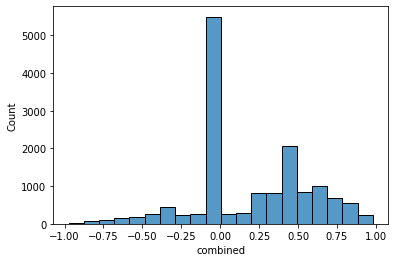

In [13]:
import seaborn as sns
sns.histplot(data=result, x='combined',bins=20)

<AxesSubplot:xlabel='inc/dec', ylabel='Count'>

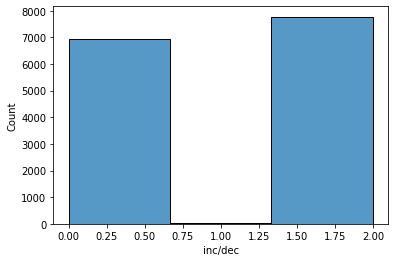

In [14]:
sns.histplot(data=result, x='inc/dec',bins=3)

# Last Step 

In [15]:
df.groupby(['Date'])[['combined','negative','neutral','positive','inc/dec']]\
    .mean().reset_index(drop=True)\
    .to_csv('data/finaldata.csv',index=False, header=True)